# Weather Image Recognition

# Imports

In [101]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.inception_v3 import InceptionV3

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

# Functions

In [92]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_process_images(img_path, target_size=(250, 250)):
  try:
    with Image.open(img_path) as img:
      img = img.resize(target_size)
      img = img.convert("RGB")
      
      img_array = np.array(img)/ 255.0
      img_array = img_array.astype(np.float32)
    return img_array
  except IOError as e:
    print(f"Error loading image {img_path}: {e}")
    return None

def grab_images(directory):
  
  images, labels = [], []

  for root, dir, files in os.walk(directory):
    for file in files:
      if file.lower().endswith((".png", ".jpeg", "jpg")):
        file_path = os.path.join(root, file)
        img = load_process_images(file_path)
        if img is not None:
          images.append(img)
          label = root.split(os.sep)[-1]
          labels.append(label)
  
  images, labels = np.array(images), np.array(labels)
  return images, labels

def check_image_class_balance(target):
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10,6))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10,6))
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.title("Count plot of target classes")
  plt.xticks(rotation=45)
  plt.show()

def create_model(n_classes):
  
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(250,250,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(n_classes, activation="softmax")
  ])
  
  model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  
  model.summary()
  
  return model

def plot_learning_curves(history):
  acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
  loss, val_loss = history.history["loss"], history.history["val_loss"]
  epochs = range(1, len(acc)+1)
  
  plt.figure(figsize=(15, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, "bo-",label="Training Accuracy")
  plt.plot(epochs, val_acc, "gs-", label="Validation Accuracy")
  plt.title("Training & Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, "bo-", label="Training Loss")
  plt.plot(epochs, val_loss, "gs-", label="Validation Loss")
  plt.title("Training & Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  
  plt.show()
  plt.tight_layout()

# Model Description

## MaxPooling2D(2,2):

- Purpose: To reduce the spatial dimensions (width and height) of the input volume. This reduces the number of parameters and computations in the network, and it also helps to make the detected features more robust to spatial variations.
(2,2) Pool Size: This is a common choice as it reduces each dimension by a factor of 2, effectively reducing the volume of the feature map by 75%. For instance, if the input size is 64x64, max pooling with (2,2) would reduce it to 32x32.

## Conv2D with (3,3) Kernel Size:

- Purpose: To apply a filter to the input volume and generate feature maps. The filters (or kernels) slide over the input spatial dimensions (width and height) to detect various features.
(3,3) Kernel Size: This is a common choice because it is large enough to capture simple patterns like edges and textures but not too large to miss finer details. It strikes a balance between complexity and computational efficiency.

## Flatten Layer:

- Purpose: To convert the 3D output of the convolutional layers into a 1D vector that can be fed into fully connected (dense) layers. The dense layers require a 1D input.
Transition: This is necessary because convolutional layers preserve the spatial structure of the data, while dense layers do not.

## Dense Layer after Flatten Layer:

- Purpose: To perform classification based on the features extracted by the convolutional layers. The dense layer can learn complex combinations of these features.
- Dense(64, activation="relu"): The dense layer with 64 neurons can learn high-level combinations of features. The ReLU activation introduces non-linearity, allowing the model to learn more complex functions.

# Load Dataset

In [68]:
PATH = "/Users/maukanmir/Downloads/dataset/"

In [69]:
X, y = grab_images(PATH)

In [70]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [71]:
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 4116
Validation set size: 1373
Test set size: 1373


# Check Class Imabalance

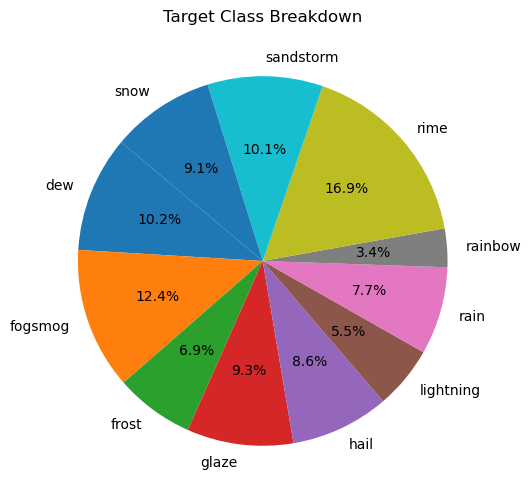

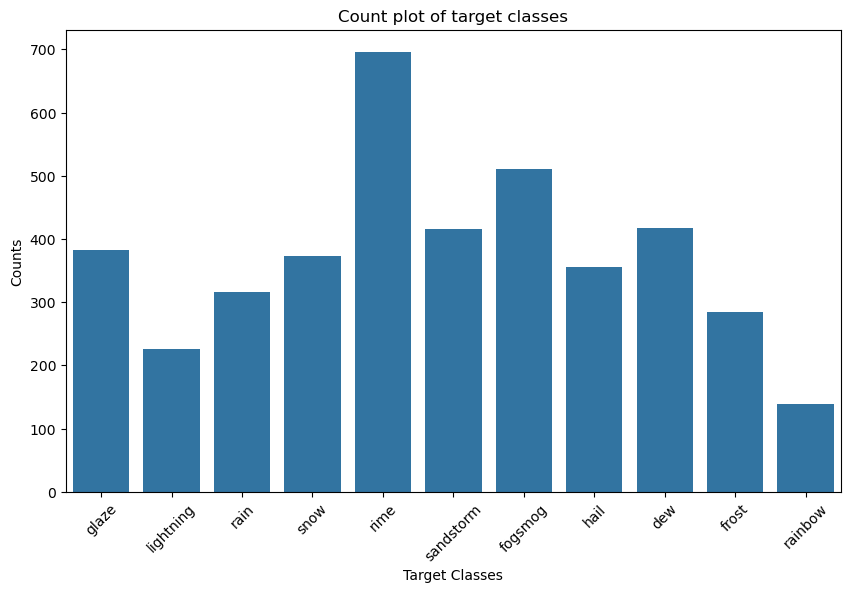

In [72]:
check_image_class_balance(y_train)

# Label Encoding

In [73]:
label_encoder = LabelEncoder()
y_train_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.transform(y_test)

n_classes = len(label_encoder.classes_)

y_train = to_categorical(y_train_int, num_classes=n_classes)
y_val = to_categorical(y_val_int, num_classes=n_classes)
y_test = to_categorical(y_test_int, num_classes=n_classes)

# Data Augmentation

In [74]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode="nearest"
)

validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
  X_train, y_train,
  batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow(
  X_val, y_val,
  batch_size=BATCH_SIZE
)

test_generator = test_datagen.flow(
  X_test, y_test,
  batch_size=BATCH_SIZE
)

# Create Model

In [75]:
model = create_model(y_train.shape[1])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 29, 29, 128)     

In [76]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=10,
    verbose=0,
    mode='min',
    restore_best_weights=True
)

# Train Model

In [78]:
history = model.fit(
  train_generator,
  steps_per_epoch=len(X_train)//BATCH_SIZE,
  epochs=12,
  validation_data=validation_generator,
  validation_steps=len(X_val)//BATCH_SIZE,
  callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_test) // 32)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/15
128/128 [==============================] - 47s 367ms/step - loss: 1.3239 - accuracy: 0.5495 - val_loss: 1.0629 - val_accuracy: 0.6176
Epoch 2/15
128/128 [==============================] - 48s 371ms/step - loss: 1.2942 - accuracy: 0.5534 - val_loss: 1.0004 - val_accuracy: 0.6555
Epoch 3/15
128/128 [==============================] - 49s 379ms/step - loss: 1.2912 - accuracy: 0.5480 - val_loss: 1.0438 - val_accuracy: 0.6406
Epoch 4/15
128/128 [==============================] - 49s 381ms/step - loss: 1.2592 - accuracy: 0.5690 - val_loss: 1.0205 - val_accuracy: 0.6562
Epoch 5/15
128/128 [==============================] - 49s 384ms/step - loss: 1.2531 - accuracy: 0.5649 - val_loss: 1.0732 - val_accuracy: 0.6399
Epoch 6/15
128/128 [==============================] - 50s 387ms/step - loss: 1.2294 - accuracy: 0.5803 - val_loss: 1.0268 - val_accuracy: 0.6376
Epoch 7/15
128/128 [==============================] - 49s 385ms/step - loss: 1.2317 - accuracy: 0.5801 - val_loss: 0.9700 - val_ac

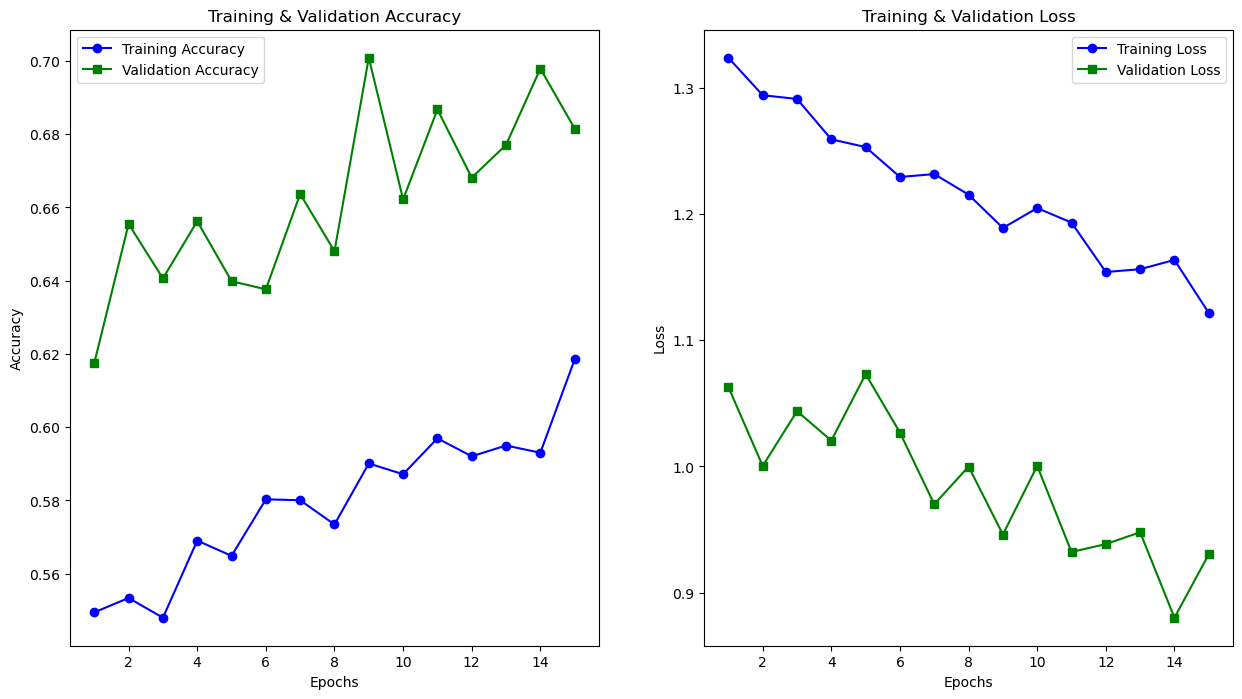

<Figure size 640x480 with 0 Axes>

In [84]:
plot_learning_curves(history)

In [86]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy", test_accuracy)

43/43 [==============================] - 4s 88ms/step - loss: 0.9780 - accuracy: 0.6737
Test Accuracy 0.6737071871757507


# Lets try Transfer Learning

In [108]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(250,250,3))

for layer in base_model.layers:
  layer.trainable = False

X = base_model.output
X = GlobalAveragePooling2D()(X)
X= Dense(128, activation="relu")(X)
X=Dropout(0.2)(X)
prediction = Dense(y_train.shape[1], activation="softmax")(X)

model_v3 = Model(inputs=base_model.input, outputs=prediction)
early_stopping = EarlyStopping(patience=2, monitor="val_loss", restore_best_weights=True)

model_v3.compile(
  loss="categorical_crossentropy",
  optimizer="adam",
  metrics=["accuracy"]
)

history = model_v3.fit(
  train_generator,
  steps_per_epoch=len(X_train)//BATCH_SIZE,
  epochs=12,
  validation_data=validation_generator,
  validation_steps=len(X_val)//BATCH_SIZE,
  callbacks=[early_stopping]
)

Epoch 1/12
128/128 [==============================] - 58s 448ms/step - loss: 1.1392 - accuracy: 0.6202 - val_loss: 0.7061 - val_accuracy: 0.7753
Epoch 2/12
128/128 [==============================] - 59s 461ms/step - loss: 0.7252 - accuracy: 0.7466 - val_loss: 0.6457 - val_accuracy: 0.7894
Epoch 3/12
128/128 [==============================] - 58s 455ms/step - loss: 0.6407 - accuracy: 0.7767 - val_loss: 0.5913 - val_accuracy: 0.8028
Epoch 4/12
128/128 [==============================] - 59s 464ms/step - loss: 0.5668 - accuracy: 0.7963 - val_loss: 0.5744 - val_accuracy: 0.7976
Epoch 5/12
128/128 [==============================] - 61s 474ms/step - loss: 0.5461 - accuracy: 0.8168 - val_loss: 0.5472 - val_accuracy: 0.8140
Epoch 6/12
128/128 [==============================] - 60s 468ms/step - loss: 0.5057 - accuracy: 0.8225 - val_loss: 0.5502 - val_accuracy: 0.8118
Epoch 7/12
128/128 [==============================] - 60s 466ms/step - loss: 0.4827 - accuracy: 0.8350 - val_loss: 0.4989 - val_ac

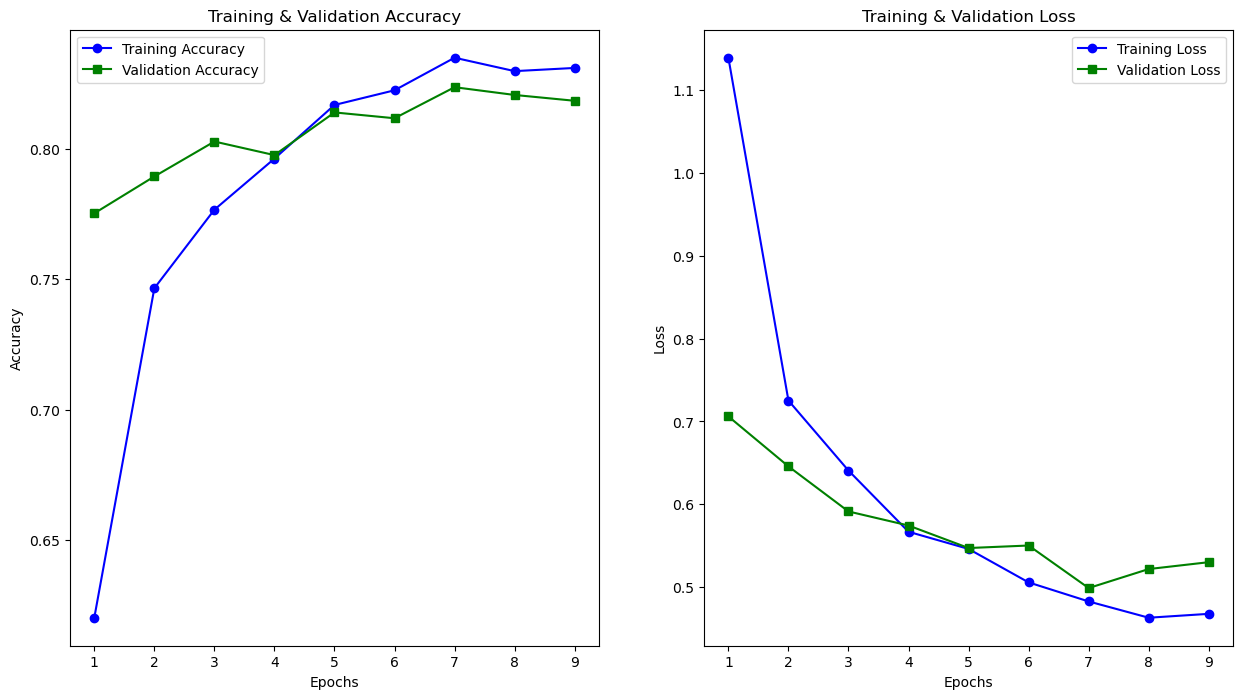

<Figure size 640x480 with 0 Axes>

In [109]:
plot_learning_curves(history)